# The Kernel Trick - Revisited

The kernel trick is a powerful tool to convert a linear method to a non-linear one. In the following, we will try to explain how and why it works. 

## Linear Models

A linear model for an input space $\mathcal{X}$ and an output space $\mathcal{Y}$ is a linear function $f:\mathcal{X}\rightarrow\mathcal{Y}$. If $\mathcal{X}\subseteq\mathbb{R}^d$, then we can describe $f$ using a vector of coefficients $\beta\in\mathbb{R}^d$, i.e., $f(x)=\beta^\top x = \langle\beta,x\rangle$ (here we are ignoring the intercept).

## The Dual Problem

### An Example: Classification with the Hinge Loss

Let us assume that we want to solve a classification problem, i.e., $\mathcal{Y}=\{-1,1\}$, and we measure the error our model makes by the hinge loss
$$\ell(f(x),y) = \max\{0, 1 - f(x)y\} = \max\{0, 1 - \langle\beta,x\rangle y\}$$
That is, our model outputs a score $\beta^\top x$ and we interpret this score as class $1$ if $\langle\beta,x\rangle\geq 0$ and as $-1$, otherwise. Thus, the model makes a correct prediction, whenever $sgn(\langle\beta,x\rangle) = y \Leftrightarrow \langle\beta,x\rangle y \geq 0$. However, the hinge loss demands not only that the prediction is right, but also that the score is larger than $1$. 

Given a dataset $X\subset\mathcal{X}$ of size $n\in\mathbb{N}$ and corresponding labels $y\subset\mathcal{Y}$, we want to find model parameters that lead to correct predictions, but like in Ridge regression, we also would like to have parameters of small squared norm $\|\beta\|_2^2$. For simplicity, let us assume we could predict $y$ perfectly from $x$. Then we are trying to find the optimal parameters $\beta$, i.e.,
$$\min_{\beta\in\mathbb{R}^d}\frac{1}{2}\|\beta\|_2^2\ \ s.t.\ \forall i\in [n]:\langle\beta,x_i\rangle y_i\geq 1$$

### The Lagrangian

We can solve the above optimization problem using the Lagrangian
$$L(\beta,\alpha)=\frac{1}{2}\beta^\top\beta - \sum_{i=1}^n\alpha_i\left(\langle\beta,x_i\rangle y_i - 1\right)$$
and maximize
$$\min_{\beta\in\mathbb{R}^d}\max_{\alpha\geq 0}\frac{1}{2}\beta^\top\beta - \sum_{i=1}^n\alpha_i\left(\langle\beta,x_i\rangle y_i - 1\right)\enspace .$$
Now, under some conditions (Slater's condition ensures the Karush-Kuhn-Tucker conditions) we can swap the min and the max and get the dual problem
$$\max_{\alpha\geq 0}\min_{\beta\in\mathbb{R}^d}\frac{1}{2}\beta^\top\beta - \sum_{i=1}^n\alpha_i\left(\langle\beta,x_i\rangle y_i - 1\right)\enspace .$$
In this form, we can solve this for the optimal $\beta$ in terms of $\alpha$ by setting the gradient to zero, i.e.,
$$\frac{\partial L}{\partial\beta}=\beta - \sum_{i=1}^n\alpha_ix_iy_i \stackrel{!}{=}0 \Leftrightarrow \beta = \sum_{i=1}^n\alpha_ix_iy_i\enspace ,$$
which we can substitue back into our dual problem and get
\begin{equation*}
\begin{split}
&\max_{\alpha\geq 0}\frac{1}{2}\left(\sum_{i=1}^n\alpha_ix_iy_i\right)^\top\left(\sum_{j=1}^n\alpha_jx_jy_j\right) - \sum_{i=1}^n\alpha_i\left(\langle\sum_{j=1}^n\alpha_jx_jy_j,x_i\rangle y_i - 1\right)\\
&=\max_{\alpha\geq 0}\frac{1}{2}\sum_{i,j=1}^n\alpha_i\alpha_jy_iy_j\langle x_i,x_j\rangle - \sum_{i,j=1}^n\alpha_i\alpha_jy_iy_j\langle x_i,x_j\rangle + \sum_{i=1}^n\alpha_i\\
&=\max_{\alpha\geq 0}\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^n\alpha_i\alpha_jy_iy_j\langle x_i,x_j\rangle\enspace .
\end{split}
\end{equation*}
This is a quadratic optimization problem which can be solved using some standard solver. If we found the optimal parameters $\alpha$, we can then compute the optimal parameters $$\beta=\sum_{i=1}^n\alpha_ix_iy_i\enspace .$$
Now, how would our linear model then look like? Well, we can just substitute the formula for $\beta$ directly and get
$$f(x)=\sum_{i=1}^n\alpha_iy_i\langle x_i, x\rangle\enspace .$$
If we now rewrite our $\alpha$'s a bit and say $\alpha'_i = \alpha_i y_i$ we get the dual representation of our model $f$, i.e.,
$$f(x)=\sum_{i=1}^n\alpha'_i\langle x_i, x\rangle\enspace .$$

Now, we found that nice representation for this special case. However, the representer theorem (Schölkopf, Herbrich, Smola) guarantees that we can always find such a representation. In a simplified form it says that if we have a loss function $\ell$, a training set $X,y$ of size $n$, a strictly increasing real-valued function $g$, and an inner product $\langle\cdot,\cdot\rangle$, then the linear function minimizing the regularized loss, i.e., 
$$f^* = \arg\min_{f\in\mathcal{H}}\sum_{i=1}^n\ell(f(x_i),y_i) + g(\|f\|)$$
can be represented as
$$f^*(\cdot)=\sum_{i=1}^n\alpha_i\langle x_i, \cdot\rangle\enspace .$$
Here, $f(\cdot)$ means we can insert any $x\in\mathcal{X}$. Moreover, $\mathcal{H}$ is the Hilbert of linear functions from $\mathcal{X}$ to $\mathcal{Y}. Now, this is a simplified version only for the standard dot product. We will discuss the full version below.

### Excursion: Max-Margin Classifiers
Before we go to the kernel trick, let us just do a small excercise to show why using the hinge loss for classification makes sense. For that let's assume a simple 2d binary classification example.

In [2]:
#some general imports
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

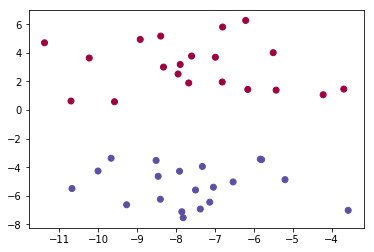

In [221]:
from sklearn.datasets.samples_generator import make_blobs, make_moons
X, y = make_blobs(n_samples = 40, centers = 2, random_state = 43, cluster_std = 1.8)
plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral')
plt.show()

Now there are many possible linear models that perfectly fit the data.

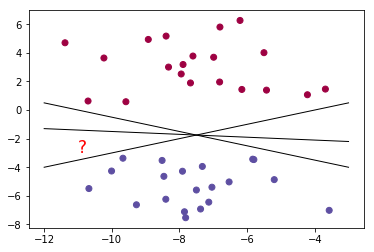

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral')
lspace = np.linspace(-12,-3)
plt.plot(lspace, -0.5*lspace -5.5, '-k', linewidth=1.)
plt.plot(lspace,  0.5*lspace +2.0, '-k', linewidth=1.)
plt.plot(lspace, -0.1*lspace -2.5, '-k', linewidth=1.)

plt.annotate('?', (-11,-3), color='red', fontsize='xx-large')
plt.show()

So which of these models is better? Well, the one with the largest margin!

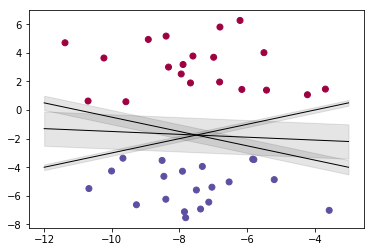

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral')
lspace = np.linspace(-12,-3)
plt.plot(lspace, -0.5*lspace -5.5, '-k', linewidth=1.)
plt.plot(lspace,  0.5*lspace +2.0, '-k', linewidth=1.)
plt.plot(lspace, -0.1*lspace -2.5, '-k', linewidth=1.)

plt.fill_between(lspace,  -0.5*lspace -5.5 -0.5, -0.5*lspace -5.5 +0.5, edgecolor='none', color='k', alpha=0.1)
plt.fill_between(lspace,   0.5*lspace +2.0 -0.2,  0.5*lspace +2.0 +0.2, edgecolor='none', color='k', alpha=0.1)
plt.fill_between(lspace,  -0.1*lspace -2.5 -1.2, -0.1*lspace -2.5 +1.2, edgecolor='none', color='k', alpha=0.1)

plt.show()

So, our goal is to find the linear model with the largest margin, the maximum margin classifier. So given our function $f(x)=\beta^\top x=$, what is it's margin? Well, since we optimize for the hinge loss, we know that the closest points to our decision boundary fulfill $\langle\beta,x\rangle y - 1 = 0$ and thus the two hyperplanes defining the boarders of the margin $H_1$ and $H_{-1}$ are given by $\langle\beta,x\rangle = 1$, respectively $\langle\beta,x\rangle = -1$. The linear model is the hyperplane $H_0$ in between with $\langle\beta,x\rangle = 0$. 


In [256]:
from sklearn.svm import SVC # "Support vector classifier"
f = SVC(kernel='linear', C=1E10)
f.fit(X, y)
def plotDecisionFunction(ax, f, showSVs = False, cmap=None):
    x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 30)
    y = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    
    grid = np.vstack([X.ravel(), Y.ravel()]).T
    decFunc = f.decision_function(grid).reshape(X.shape)
    if cmap is None:
        ax.contour(X, Y, decFunc, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'], alpha=0.6)
    else:
        ax.contourf(X, Y, decFunc, cmap=cmap, alpha=0.3)
    if showSVs:
        ax.scatter(f.support_vectors_[:,0], f.support_vectors_[:,1], linewidth=1.1, facecolors='None', edgecolor = 'k', s=250)

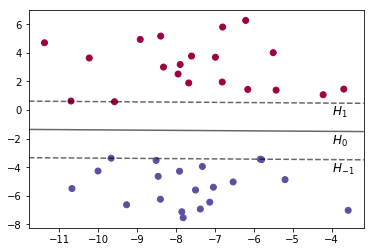

In [7]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral')
ax = plt.gca()
plotDecisionFunction(ax,f)
plt.annotate(r'$H_1$', (-4,-0.4), fontsize='large')
plt.annotate(r'$H_0$', (-4,-2.4), fontsize='large')
plt.annotate(r'$H_{-1}$', (-4,-4.4), fontsize='large')
plt.show()

The distance of a point $x$ to a hyperplane $\beta^\top x = 0$ is given by 
$$\frac{|\beta^\top x|}{\|\beta\|}\enspace .$$
(this is because $\beta$ is a normal vector to the plane; the signed distance of a point $x$ to a plane $\beta^\top x = 0$ can be obtained by first normalizing $\widehat{\beta}=\frac{\beta}{\|\beta\|}$ and then computing the dot product $\widehat{\beta}^\top x = \frac{\beta^\top x}{\|\beta\|}$; the unsigned distance is the absolute of this).

Pick any point on $H_1$, then its distance to $H_0$ is $\frac{1}{\|\beta\|}$, since $\beta^\top x = 1$. Similarly, for any point on $H_{-1}$. Thus, the total margin is 
$$\frac{2}{\|\beta\|}\enspace .$$
If we want to maximize this margin, we need to minimize $\beta$ and use the hinge loss. And that was exactly what we were doing! 

### A Side-Note

We are already in an excursion and I am making another side note. I am sorry, bear with me. In the example above, we found that there will be some points directly on the margin. Actually, the hyperplane $H_0$ and with it the model $f$ is uniquely defined by the points on the margin. The position of all other points is utterly irrelevant. That is why these points are called \textbf{support vectors}. 




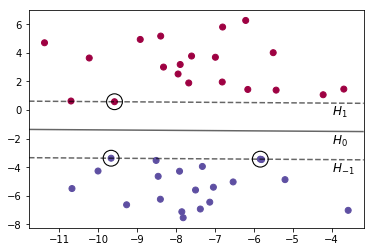

In [8]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral')
ax = plt.gca()
plotDecisionFunction(ax,f, True)
plt.annotate(r'$H_1$', (-4,-0.4), fontsize='large')
plt.annotate(r'$H_0$', (-4,-2.4), fontsize='large')
plt.annotate(r'$H_{-1}$', (-4,-4.4), fontsize='large')
plt.show()

And now the loop closes. In our newly found representation 
$$f(\cdot)=\sum_{i=1}^n\alpha_i\langle x_i, \cdot\rangle$$
we define the hyperplane that is our linear model as a linear combination of elements in our training set. And guess what? All $\alpha_i=0$ except for those $x_i$ that are directly on the boundary of the margin. Thus, all $x_i$ with $\alpha_i\neq 0$ are our support vectors. So, we just derived a hard-margin SVM. 

But now, back to the kernel trick.

### What have we achieved?

So far, a bit less than nothing. We found a more complicated way to find our linear model, and we can now represent our model in a slightly more complicated way. Now, there are special cases in which this dual represenation can actually be advantageous. If the number of features is far larger than the number of samples, i.e., $d>>n$, then computing the dual representation is cheaper than the primal. The same holds for solving the optimization problem (please recall Mario's presentation on kernel methods that showed this in detail).

However, this dual represenation will come in very handy when we apply the kernel trick. So let's get there.

## Non-Linear Models

To motivate the kernel trick, I will follow the example given here: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html.

So far, we have seen that we can represent a linear model using the training set and we have seen that we can directly optimize the model using this representation by solving the Lagrangian dual. We also have seen that using the hinge loss and minimizing $\beta$ leads to a maximum margin classifier and that the points exactly on the margin are the support vectors. 

But what about data distributions that cannot be described by a linear model? Let's look at a simple example.

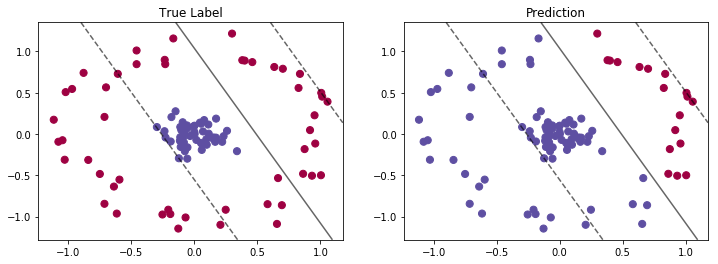

In [9]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

f = SVC(kernel='linear').fit(X, y)
pred = f.predict(X)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,4))
ax1.set_title('True Label')
ax2.set_title('Prediction')
ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Spectral')
plotDecisionFunction(ax1,f, False)
ax2.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='Spectral')
plotDecisionFunction(ax2,f, False)

As we can see, the linear model is utterly useless. But what if we would preprocess our data? That is, what if we have a function $\varphi:\mathbb{R}^d\rightarrow F$ that maps our original data from $\mathcal{X}\subseteq\mathbb{R}^d$ into a (typically higher dimensional) feature space $F$? Let's construct one such $\varphi$ for our example. For that we add to the features a Gaussian centered around the origin, i.e., 
$$\varphi(x) = \left(x_1,x_2,\dots,x_d,e^{-\|x\|_2^2}\right)\enspace .$$
In this case, we know that how the feature space looks like, i.e., $F\subseteq\mathbb{R}^{d+1}$. For our example, we can even visualize this.

In [10]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

phi = np.exp(-(X ** 2).sum(1))

def plotPhi(X=X, y=y, tilt=25, turn=-40):
    f = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], phi, c=y, s=50, cmap='Spectral')
    ax.view_init(elev=tilt, azim=turn)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_zlabel(r'$e^{-\|x\|_2^2}$')

interact(plotPhi, X=fixed(X), y=fixed(y), tilt=(-50, 50), turn=(-180, 180))
plt.show()

interactive(children=(IntSlider(value=25, description='tilt', max=50, min=-50), IntSlider(value=-40, descripti…

Now we can find a trivial linear model by simply deciding the class based on $e^{-\|x\|_2^2}$, e.g., whether it is smaller than $0.5$.

However, this feature map was tuned to the example. In general, this feature map does not work. If we would shift the data just a bit (e.g. by 1 in each direction), this does not work anymore.

In [11]:
X_shift = X + np.ones(X.shape)
phi_shift = np.exp(-(X_shift ** 2).sum(1))

def plotPhi(X=X, y=y, tilt=25, turn=-40):
    f = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], phi_shift, c=y, s=50, cmap='Spectral')
    ax.view_init(elev=tilt, azim=turn)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_zlabel(r'$e^{-\|x\|_2^2}$')

interact(plotPhi, X=fixed(X_shift), y=fixed(y), tilt=(-50, 50), turn=(-180, 180))
plt.show()

interactive(children=(IntSlider(value=25, description='tilt', max=50, min=-50), IntSlider(value=-40, descripti…

So, what we need is a feature map that always works. Let's stay with a two-dimensional example.

### Polynomial Feature Maps

Let's try to create a feature map that could work for this example. For that, let's try to get some non-linearities in the feature map, but fairly generic ones. At let's stay modest with the non-linearity. E.g., let's fix a constant $c\in\mathbb{R}$ and define
$$\varphi_{poly}(x)=\left(x_1^2,x_2^2,\sqrt{2}x_1x_2,\sqrt{2c}x_1,\sqrt{2c}x_2,c\right)\enspace .$$
Now, of course, we cannot plot the feature space anymore. But we can check how well a linear model would work with this feature space.


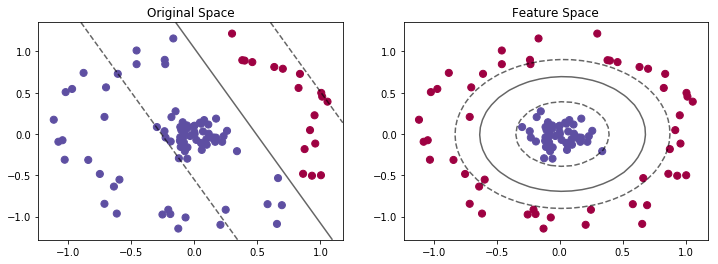

In [12]:
c = 1.0
phiX = np.array([[x[0]**2,x[1]**2,math.sqrt(2)*x[0]*x[1],math.sqrt(2*c)*x[0],math.sqrt(2*c)*x[1],c] for x in X])

flin = SVC(kernel='linear').fit(X, y)
pred = flin.predict(X)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,4))
ax1.set_title('Original Space')
ax1.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='Spectral')
plotDecisionFunction(ax1,flin, False)

fphi = SVC(kernel='linear').fit(phiX, y)
pred = fphi.predict(phiX)
ax2.set_title('Feature Space')
ax2.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='Spectral')

#We need to plot the decision boundary a bit differently here. Maybe I should make the initial function a bit more modular.
x1_c = np.linspace(ax2.get_xlim()[0], ax2.get_xlim()[1], 30)
x2_c = np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 30)
X1c, X2c = np.meshgrid(x1_c, x2_c)

grid = np.vstack([X1c.ravel(), X2c.ravel()]).T
phiGrid = np.array([[x[0]**2,x[1]**2,math.sqrt(2)*x[0]*x[1],math.sqrt(2*c)*x[0],math.sqrt(2*c)*x[1],c] for x in grid])
decFunc = fphi.decision_function(phiGrid).reshape(X2c.shape)
ax2.contour(X1c, X2c, decFunc, levels=[-0.8, 0, 0.8], colors='k', linestyles=['--', '-', '--'], alpha=0.6)
plt.show()

This feature map $\varphi_{poly}$ seems to work quite well and it is pretty generic. So let us write our model in the dual representation using the feature map. We get
$$f(x)=\sum_{i=1}^n\alpha_i\langle\varphi_{poly}(x_i),\varphi_{poly}(x)\rangle\enspace .$$
Let us look at this inner product a bit more closely. Assume to vectors $x,z\in\mathcal{X}$ (and let's abbreviate $\varphi_{poly}=\varphi$ for the moment), what does it look like?
\begin{equation*}
\begin{split}
\langle\varphi(x),\varphi(z)\rangle =& \left\langle\left(x_1^2,x_2^2,\sqrt{2}x_1x_2,\sqrt{2c}x_1,\sqrt{2c}x_2,c\right), \left(z_1^2,z_2^2,\sqrt{2}z_1z_2,\sqrt{2c}z_1,\sqrt{2c}z_2,c\right) \right\rangle\\
=& x_1^2z_1^2 + x_2^2z_2^2 + 2x_1x_2z_1z_2 + 2x_1z_1c + 2x_2z_2c + c^2\\
=& (\underbrace{x_1z_1}_{=:\xi_1})^2 + (\underbrace{x_2z_2}_{=:\xi_2})^2 + 2(x_1z_1)(x_2z_2) + 2c(x_1z_1) + 2c(x_2z_2) + c^2\\
=& \xi_1^2 + 2\xi_1\xi_2 + \xi_2^2  + 2c\xi_1 + 2c\xi_2 + c^2\\
=& (\xi_1 + \xi_2)^2 + 2c(\xi_1+\xi_2) + c^2\\
=&\left((\xi_1 + \xi_2) + c\right)^2\\
=&\left((x_1z_1 + x_2z_2) + c\right)^2\\
=&\left(\langle x,z \rangle + c\right)^2
\end{split}
\end{equation*}
So, what we have seen is that we can explress the inner product in feature space $\langle\varphi(x),\varphi(z)\rangle$ by a much simpler function $\left(\langle x,z \rangle + c\right)^2$.

## An Intuitive Perspective on the Kernel Function

In our model representation and in our optimization problem, we only ever need to compute $\langle\varphi_{poly}(x),\varphi_{poly}(z)\rangle$ and never need the actual point in feature space $\varphi_{poly}(x)$. That is good, because it means we can instead use our simpler function $k_{poly}(x,z) = \left(\langle x,z \rangle + c\right)^2$ to compute that inner product. 

For this particular function $k$ we can guarantee that if we replace the inner product in the model and the Lagrangian with $k_{poly}$, we get the linear model in the feature space that $\varphi_{poly}$ maps to. Our new model then is
$$f(\cdot) = \sum_{i=1}^n \alpha_i k_{poly}(x_i,\cdot)$$
and the Lagrangian optimization problem is
$$\max_{\alpha\geq 0}\sum_{i=1}^n\alpha_i-\frac{1}{2}\sum_{i,j=1}^n\alpha_i\alpha_jy_iy_jk_{poly}(x_i,x_j)\enspace .$$

# Kernel Functions

We have seen that for a particular choice of $\varphi_{poly}$, we found a function $k_{poly}(\dot,\cdot)$ so that $k_{poly}(x,z) = \langle\varphi_{poly}(x),\varphi_{poly}(z)\rangle$. This implies that $k_{poly}$ is an inner product in the feature space $F$ that $\varphi_{poly}$ maps to. What about other functions $k$? 

**Mercer's thorem** states that if $k$ is positive semi-definite, i.e., for all finite sets $x_1,\dots,x_n$ and all real numbers $c_1,\dots,c_n$, it holds that
$$\sum_{i=1}^n\sum_{j=1}^n k(x_i,x_j)c_1c_j \geq 0\enspace ,$$
then there exists _some_ $\varphi$ such that $k(x,z)$ corresponds to _some_ inner product $\langle\varphi(x),\varphi(z)\rangle_F$ in $F$. Let's look at that a bit more closely.

## Mercer's Theorem

If we have a function $k:\mathcal{X}\times\mathcal{X}\rightarrow \mathbb{R}$ that is positive semi-definite then we can define the associated Hilbert-Schmidt integral operator (a linear operator) over the space $\mathcal{L}^2$ of square-integrable real-valued functions
$$[T_k f](x) = \int_\mathcal{X}k(z,x)\varphi(z)dz$$
for all $f\in\mathcal{L}^2$ and $x\in\mathcal{X}$. Now, what Mercer's theorem says is the following.

If $k$ is symmetric and positive-semidefinite, then there exists an orthonormal basis $\{e_i\}_{i=1}^\infty$ of $\mathcal{L}^2$ where the $e_i$ are the Eigenfunctions of $T_k$ such that the corresponding sequence of Eigenvalues $\{\lambda_i\}_{i=1}^\infty$ is non-negative. The Eigenfunctions corresponding to non-zero Eigenvalues of $T_k$ are continuous on $\mathcal{X}$ and $k$ has the representation
$$k(x,z) = \sum_{i=1}^\infty \lambda_i e_i(x) e_i(z)\enspace .$$

Now what does that mean for us? We can basically ignore the whole part about the integral operator and just look at that last equation. It guarantees that for any **symmetric and positive-semidefinite** function $k(\cdot,\cdot)$ there exists a feature map $\varphi(x)=(e_1(x),e_2(x),\dots)$ such that $k$ is an inner product in the feature space that $\varphi$ maps to. 

_Note:_ It is not the standard inner product, but one where each dimension is scaled by a non-negative factor $\lambda_i$. 

## Reproducing Kernel Hilbert Spaces

Assume a Hilbert space $\mathcal{H}$ (vector space with inner product and norm) of real-valued functions over $\mathcal{X}$. The evaluation functional $L_x:\mathcal{H}\rightarrow\mathbb{R}$ evaluates each function $f\in\mathcal{H}$ at the point $x\in\mathcal{X}$, i.e., $L_x(f) = f(x)$. 

_Note:_ That's a very weird way to describe the evaluation of a function. Usually, you fix $f$ and then evaluate $f$ at all possible $x$. Here, you fix one $x$ with corresponding $L_x$ and then evaluate it at all possible $f$. In both cases, what you get in the end is simply $f(x)$.

Now $\mathcal{H}$ is a reproducing kernel Hilbert space, if $L_x$ is continuous at any $f\in\mathcal{H}$. This means, for every $L_x$ there exists a corresponding function $k_x$ such that 
$$L_x(f) = \langle k_x, f\rangle = f(x)\enspace .$$
With this, we can define the **reproducing kernel**
$$k(x,z) = \langle k_x, k_z\rangle$$
which is symmetric and positive-semidefinite.

Now, the Moore–Aronszajn theorem guarantees that the converse is also true: if we have a symmetric and positive-semidefinite function $k$, then there existis a corresponding reproducing kernel Hilbert space of real-valued functions.

## Feature Maps and RKHS

We have seen above that for our symmetric and positive-semidefinite function $k$ there always exists some feature map $\varphi$ such that $k(x,z)=\langle\varphi(x),\varphi(z)\rangle_F$ for some feature space $F$. Moreover, we know that there always exists a reproducing kernel Hilbert space $H_k$ of real-valued functions over $\mathcal{X}$. What kind of functions are in that space? 

Let's construct a Hilbert space of linear functions
$$H_\varphi = \{f:\mathcal{X}\rightarrow\mathbb{R} \mid \exists \beta\in F, f(x)=\langle\beta,\varphi(x)\rangle_F, \forall x\in\mathcal{X}\}$$
which has the norm
$$\|f\|_\varphi = \inf\{\|\beta\|_F:\beta\in F, f(x)=\langle\beta,\varphi(x)\rangle_F, \forall x\in\mathcal{X}\}\enspace .$$

**Check the source for the following!**
It can be shown that $H_\varphi$ is the reproducing kernel Hilbert space defined by $k(x,z)=\langle\varphi(x),\varphi(z)\rangle_F$. 

This implies that the real-valued functions over $\mathcal{X} in $\mathcal{H}_k$ are linear functions over the feature space $F$.


# The Kernel Trick

The kernel trick now means that as soon as we have any symmetric positive-semidefinite function $k(\cdot,\cdot)$, we can use it to calculate the inner product in the model representation. However, there is one more problem to solve: in principle this only means we can represent our model as
$$f(\cdot)=\sum_{x\in\mathcal{X}}\alpha_xk(x,\cdot)$$
which is an infinite sum. 

In the beginning, we mentioned the representer theorem and gave a simplified special case. This is the point were the full version of this theorem comes in handy. 

### The Representer Theorem (Schölkopf, Herbrich, Smola)

Let $k:\mathcal{X}\times\mathcal{X}\rightarrow\mathbb{R}$ be a symmetric and positive-semidefinite kernel over the non-empty set $\mathcal{X}$ with corresponding reproducing kernel Hilbert space $\mathcal{H}_k$. Given a training set $\left((x_1,y_1),\dots,(x_n,y_n)\right)\subset\mathcal{X}\times\mathbb{R}$ of size $n\in\mathbb{N}$, a loss function $\ell:\mathbb{R}\times\mathbb{R}\rightarrow\mathbb{R}$ and a strictly increasing real-valued function $g:[0,\infty)\rightarrow\mathbb{R}$, the regularized empirical risk on $H_k$ is defined as
$$R(f) = \sum_{i=1}^n\ell(f(x_i),y_i) + g(\|f\|)\enspace .$$
Then, any minimizer of the regularized risk
$$f^*=\arg\min_{f\in\mathcal{H}_k} R(f)$$
admits a representation of the form
$$f(\cdot) = \sum_{i=1}^n \alpha_i k(x_i,\cdot)$$


$\ell$, a training set $X,y$ of size $n$, a strictly increasing real-valued function $g$, and an inner product $\langle\cdot,\cdot\rangle$, then the linear function minimizing the regularized loss, i.e., 
$$f^* = \arg\min_{f\in\mathcal{H}}\sum_{i=1}^n\ell(f(x_i),y_i) + g(\|f\|)$$
can be represented as
$$f^*(\cdot)=\sum_{i=1}^n\alpha_i\langle x_i, \cdot\rangle\enspace .$$

# A few Examples

Let's just try out a few kernel functions on some example data.

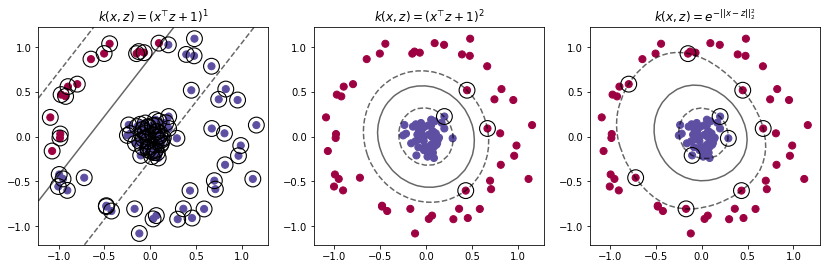

In [27]:
# Polynomial kernel d=1
X, y = make_circles(100, factor=.1, noise=.1)

fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (14,4))
f = SVC(kernel='poly', C=1E6, degree = 1)
f.fit(X, y)
pred = f.predict(X)
ax1.set_title(r'$k(x,z)=(x^\top z + 1)^1$')
ax1.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='Spectral')
plotDecisionFunction(ax1,f, True)

f = SVC(kernel='poly', C=1E6, degree = 2)
f.fit(X, y)
pred = f.predict(X)
ax2.set_title(r'$k(x,z)=(x^\top z + 1)^2$')
ax2.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='Spectral')
plotDecisionFunction(ax2,f, True)

f = SVC(kernel='rbf', C=1E6)
f.fit(X, y)
pred = f.predict(X)
ax3.set_title(r'$k(x,z)=e^{-\|\|x-z\|\|_2^2}$')
ax3.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='Spectral')
plotDecisionFunction(ax3,f, True)


plt.show()

# The Polynomial Kernel

The polynomial kernel is defined as 
$$k(x,z) = e^{-\frac{\|x-z\|_2^2}{2\sigma}}$$
and it looks as follows.

In [172]:
import matplotlib.colors as mcolors
def drawKernel(sv, sigma, ax, alpha=1.0, xmin = None, xmax = None):
    if xmin is None:
        xmin = ax.get_xlim()[0]
    if xmax is None:
        xmax = ax.get_xlim()[1]
    x_c = np.linspace(xmin, xmax, 100)
    y = alpha*np.array([np.exp(-1*np.linalg.norm(sv-x)**2 / (2*sigma)) for x in x_c])
    ax.plot(x_c, y, color='darkturquoise')
    ax.vlines(sv, 0.,alpha,colors='r', linestyles ='dashed')

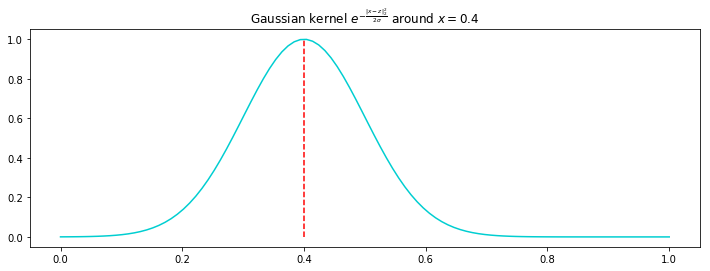

In [197]:
fig, ax = plt.subplots(1, 1, figsize = (12,4))
sv = 0.4
drawKernel(sv, .01, ax)
ax.set_title(r'Gaussian kernel $e^{-\frac{\|x-z\|_2^2}{2\sigma}}$ around $x=0.4$')
plt.show()

It is called the Gaussian kernel, or RBF kernel (for radial basis function), because it is equal to an unnormalized Gaussian. 

## Example: Regression with the Gaussian Kernel

So let's do some regression. Assume fome function $f$ that we want to approximate.

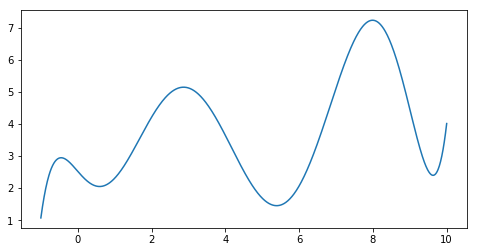

In [198]:
def f(x):
    y =  2.5220937891424464
    y -= 1.3205441719052109*x
    y += 1.5580077014371324e-001*x**2
    y += 1.7371642653756312*x**3
    y -= 9.7085004028066801e-001*x**4
    y += 2.0053450527785788e-001*x**5
    y -= 1.8017813196659842e-002*x**6
    y += 5.9348129387248665e-004*x**7
    return y

fig, ax = plt.subplots(1, 1, figsize = (8,4))
X = np.linspace(-1, 10, 1000)
Y = np.array([f(x) for x in X])
ax.plot(X,Y)
plt.show()

How would this look like if we used a support vector regression with a Gaussian kernel?

16


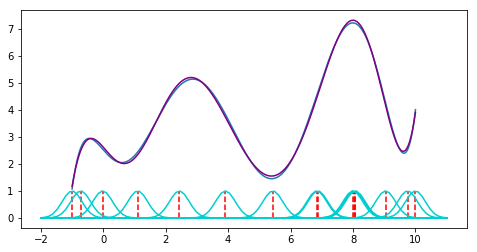

In [199]:
from sklearn.svm import SVR
gamma = .1
clf = SVR(kernel='rbf', C=100000., gamma=gamma)
X = np.linspace(-1, 10, 1000).reshape(-1,1)
Y = np.array([f(x) for x in X])
fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(X,Y)

clf.fit(X,Y)
pred = clf.predict(X)
ax.plot(X,pred, color='purple')
print(len(clf.support_vectors_))
for i in range(len(clf.support_vectors_)):
    sv = clf.support_vectors_[i]
    drawKernel(sv, gamma, ax, alpha=1.0, xmin=-2, xmax=11.)
plt.show()

However, the coefficients are a bit horrible... (around 20k) so let's regularize a bit and visualize the coefficients. :D

141


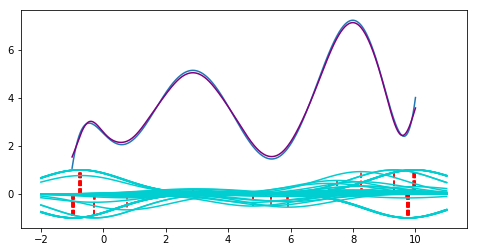

In [218]:
from sklearn.svm import SVR
gamma = 1.9
clf = SVR(kernel='rbf', C=1., gamma=gamma)
X = np.linspace(-1, 10, 1000).reshape(-1,1)
Y = np.array([f(x) for x in X])
fig, ax = plt.subplots(1, 1, figsize = (8,4))
ax.plot(X,Y)

clf.fit(X,Y)
pred = clf.predict(X)
ax.plot(X,pred, color='purple')
print(len(clf.support_vectors_))
for i in range(len(clf.support_vectors_)):
    sv = clf.support_vectors_[i]
    alpha = clf.dual_coef_.T[i]
    drawKernel(sv, gamma, ax, alpha=alpha, xmin=-2, xmax=11.)
plt.show()

## Another Example: Classification with the Gaussian Kernel

Let us look at how at how the classification depends on the kernel bandwidth sigma ($\sigma$) and the regularizuation constant $C$.

In [267]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

def plotDecisionFunctionContour(ax, f, showSVs, Xg, Yg, grid, cmap=None):
    decFunc = f.decision_function(grid).reshape(Xg.shape)
    if cmap is None:
        ax.contour(Xg, Yg, decFunc, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'], alpha=0.6)
    else:
        ax.contourf(Xg, Yg, decFunc, cmap=cmap, alpha=0.3)
    if showSVs:
        ax.scatter(f.support_vectors_[:,0], f.support_vectors_[:,1], linewidth=1.1, facecolors='None', edgecolor = 'k', s=250)

def plotSVC(sigma, C,showSVs,  X, Y, Xg, Yg, grid):
    clf = SVC(kernel='rbf', C=C, gamma=sigma)
    clf.fit(X, Y)
    pred = clf.predict(X)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(X[:,0], X[:,1], c=y, cmap='Spectral')
    plotDecisionFunctionContour(ax, clf, showSVs, Xg, Yg, grid, cmap='Spectral')
    
    fig.canvas.draw()
    
X, Y = make_moons(n_samples = 50, random_state = 43, noise =0.2)
xg = np.linspace(min(X[:,0]), max(X[:,0]), 30)
yg = np.linspace(min(X[:,1]), max(X[:,1]), 30)
Yg, Xg = np.meshgrid(yg, xg)
grid = np.vstack([Xg.ravel(), Yg.ravel()]).T

interact(plotSVC, sigma = (0.001,10.,0.1), C = (0.01,1000.,0.1), showSVs = True, X = fixed(X), Y = fixed(Y), Xg = fixed(Xg), Yg = fixed(Yg), grid = fixed(grid))


interactive(children=(FloatSlider(value=4.901000000000001, description='gamma', max=10.0, min=0.001), FloatSli…

<function __main__.plotSVC(gamma, C, showSVs, X, Y, Xg, Yg, grid)>